<a href="https://colab.research.google.com/github/brenopelegrin/lab-avancado1/blob/dev/lab_avan%C3%A7ado_interferometro_fft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bibliotecas e git clone


Installs necessary libraries and sets up git

In [53]:
!pip install LabIFSC2 ipympl
!rm -rf lab-avancado1
!git clone https://github.com/brenopelegrin/lab-avancado1.git lab-avancado1 --depth 1 --branch dev

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.3 MB/s eta 0:00:00
Cloning into 'lab-avancado1'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 53 (delta 0), reused 44 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 12.74 MiB | 20.87 MiB/s, done.


Import necessary libraries and config defaults

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sci
import LabIFSC2 as lab
import typing

import os
plt.style.use("ggplot")

## Importar dados


Imports data and defines constants to parse the data

In [3]:
NUM_POINTS = 4096
SAMPLING_RATE = 50 # ms

def carregar_dados(path: str) -> np.ndarray:
  """
  Loads data from a csv file and returns a numpy array.

  Args:
    path: The full path to the csv file.

  Returns:
    A numpy array with the data.
  """
  df = pd.read_csv(path,sep=";")
  columns_to_remove = [df.columns[x] for x in [0,2,3,4]]
  df = df.drop(columns=[*columns_to_remove])[0:NUM_POINTS-1]
  df = df.rename(columns={df.columns[0]:"voltagem"})
  correção_arduino=1/2
  df["voltagem"] = df["voltagem"].map(lambda x: lab.Medida(float(x.replace(",","."))*correção_arduino,"V", 0))
  array = df["voltagem"].to_numpy()
  return array - np.mean(array)

lambda_vermelho=lab.Medida(632.8,"nm",0)
lambda_amarelo=lab.Medida(594.1,"nm",0)


In [4]:
# Iterates through all csv files in "dados_interferometro_fft_dia_1" and imports
# the data to dados[filename]

dados: dict[str,pd.DataFrame] = {}

for root, dirs, files in os.walk("/content/lab-avancado1/dados_interferometro_fft_dia_1"):
    for filename in files:
      if filename.endswith(".csv"):
        dados[filename] = carregar_dados(os.path.join(root, filename))

tempos = np.array([lab.Medida(x*SAMPLING_RATE,"ms",0) for x in range(0,NUM_POINTS-1)])

/tmp/ipython-input-4024521753.py:14: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep=";")


## Fator de Calibração Laser Vermelho
Valor nominal: 632.8 nm

In [5]:
fft_y = np.fft.ifft(lab.nominais(dados["resultados_original_vermelho1.csv"],"mV"))
lambda_pico = len(fft_y)-np.argmax(np.abs(fft_y))
print(f"{lambda_pico=}")
#lambdas = np.array([i*(lambda_vermelho/(lambda_pico)) for i in range(len(fft_y))])
lambdas=lambda_pico*lambda_vermelho/(np.arange(1,NUM_POINTS))


lambda_pico=np.int64(3880)


## Gráficos

In [73]:
def grafico(
    nome_arquivo_csv:str,
    lambda_esperados:list[lab.Medida]=[],
    lambda_medidos:list[lab.Medida]=[],
    time_interval:tuple[lab.Medida,lab.Medida]=[lab.Medida(0,"s",0),lab.Medida(5,"s",0)],
    lambda_interval:tuple[lab.Medida,lab.Medida]=[lab.Medida(600,"nm",0),lab.Medida(800,'nm',0)]
    ) -> typing.Tuple[plt.Figure,plt.Figure]:
  """
  Generates figures based on data, time_interval and lambda_interval.
  """
  unidade_voltagem="mV"
  unidade_tempo="s"
  unidade_lambda="nm"
  dpi=100
  #figure tempo
  fig_tempo,ax_tempo=plt.subplots(figsize=(12.8,7.2),dpi=dpi)
  t_min=time_interval[0].nominal(unidade_tempo)
  t_max=time_interval[1].nominal(unidade_tempo)
  ax_tempo.set_xlim(t_min,t_max)
  voltagens = dados[nome_arquivo_csv]
  ax_tempo.plot(lab.nominais(tempos,unidade_tempo),
              lab.nominais(voltagens,unidade_voltagem),
               color="blue")
  ax_tempo.set_ylabel(f"Voltagem ({unidade_voltagem})")
  ax_tempo.set_xlabel(f"Tempo ({unidade_tempo})")
  #figure lambda
  fig_lambda,ax_lambda=plt.subplots(figsize=(12.8,7.2),dpi=dpi)
  lambda_min=lambda_interval[0]
  lambda_max=lambda_interval[1]
  ax_lambda.set_xlim(lambda_min.nominal(unidade_lambda),
                     lambda_max.nominal(unidade_lambda))
  y_fft = np.abs(np.fft.ifft(lab.nominais(voltagens,"mV")))

  ax_lambda.plot(lab.nominais(lambdas,unidade_lambda), y_fft)
  ax_lambda.set_xlabel(f"Comprimento de onda ({unidade_lambda})")
  for lambda_esperado in lambda_esperados:
    ax_lambda.axvline(lambda_esperado.nominal(unidade_lambda),alpha=0.5,
                    linestyle="dashed",
                    color="green",
                    label=f"Esperado: {lambda_esperado.nominal(unidade_lambda):.1f} nm")
  for lambda_medido in lambda_medidos:
    ax_lambda.axvline(lambda_medido.nominal(unidade_lambda),alpha=0.5,
                    color="blue",
                    label=f"Medido: {lambda_esperado.nominal(unidade_lambda):.1f}")
  ax_lambda.set_ylabel(f"Amplitude")
  ax_lambda.legend()
  return (fig_tempo, fig_lambda)

## Vermelho (Calibração)

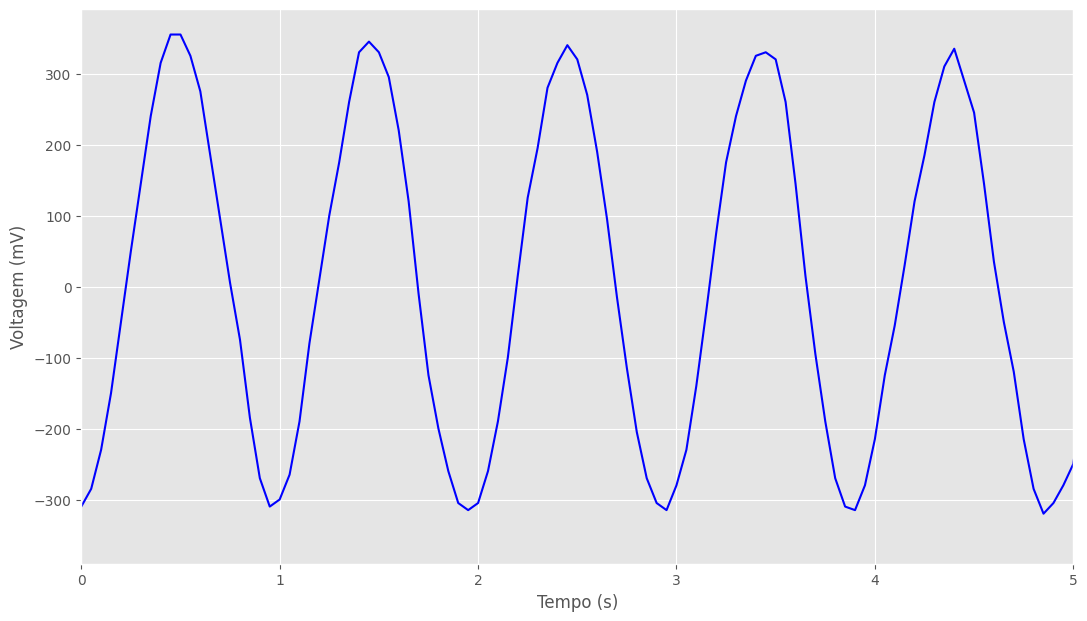

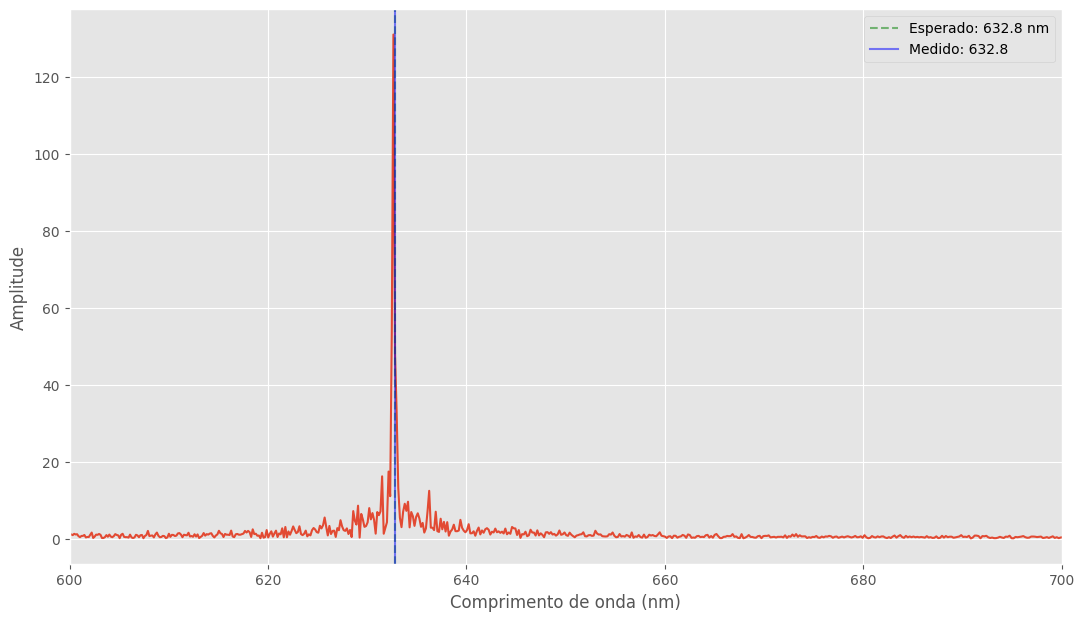

In [74]:
fig_tempo, fig_lambda = grafico("resultados_original_vermelho1.csv",
                                lambda_esperados=[lambda_vermelho],
                                lambda_medidos=[lambda_vermelho],
                                lambda_interval=[lab.Medida(600,"nm",0),
                                                 lab.Medida(700,'nm',0)])
fig_tempo.show()
fig_tempo.savefig("tempo_vermelho.png")
fig_lambda.savefig("lambda_vermelho.png")

## Verde

/tmp/ipython-input-104497967.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_lambda.legend()


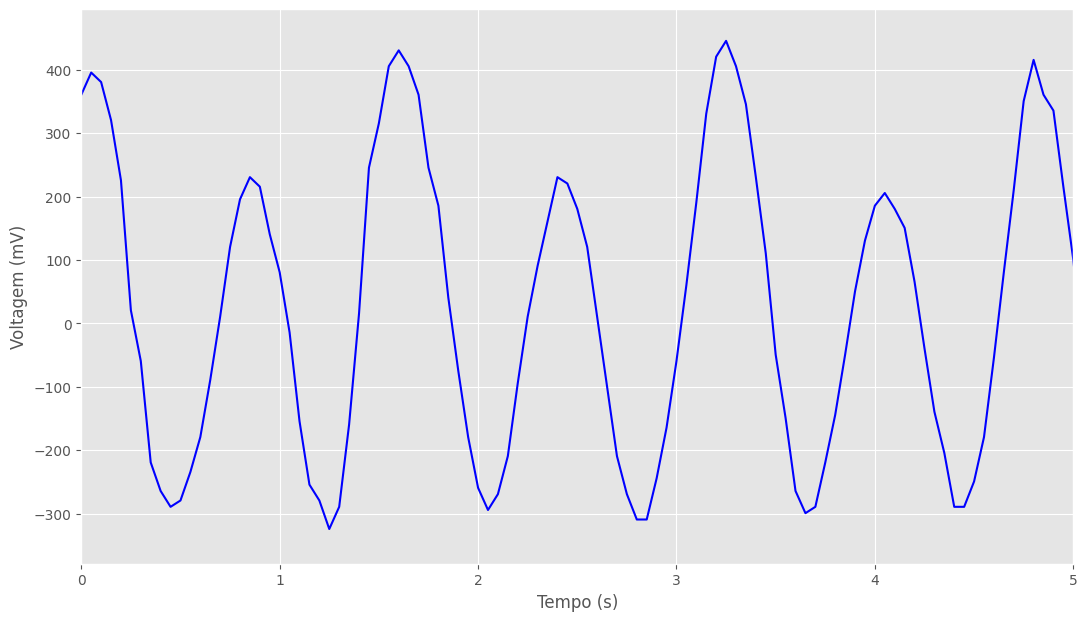

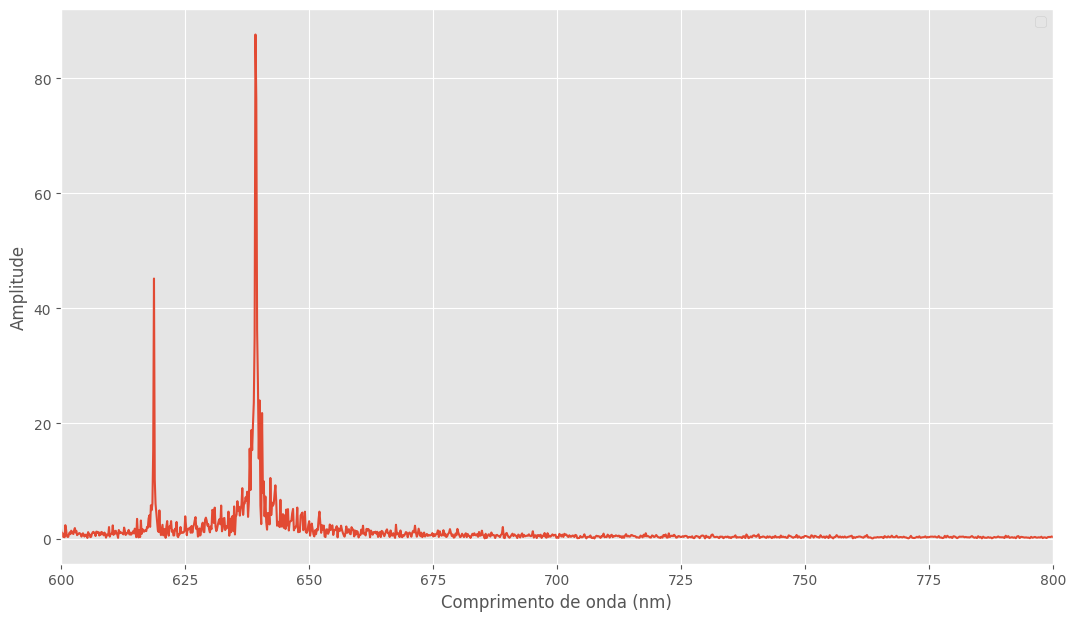

In [75]:
fig_tempo, fig_lambda = grafico("verde_foda.csv")
fig_tempo.savefig("tempo_verde.png")
fig_lambda.savefig("lambda_verde.png")

## Amarelo

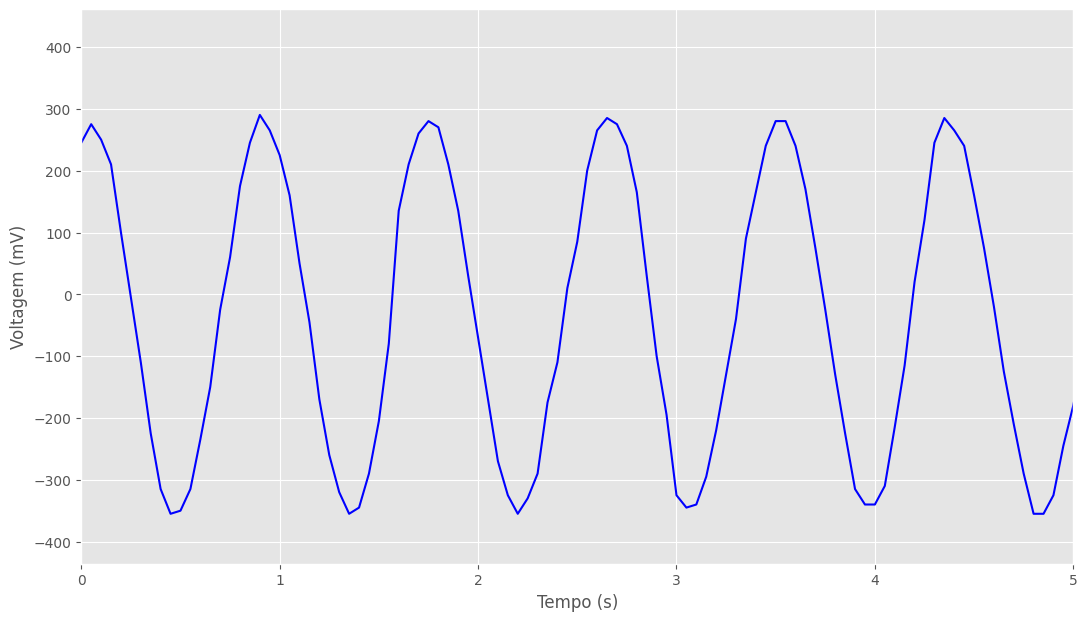

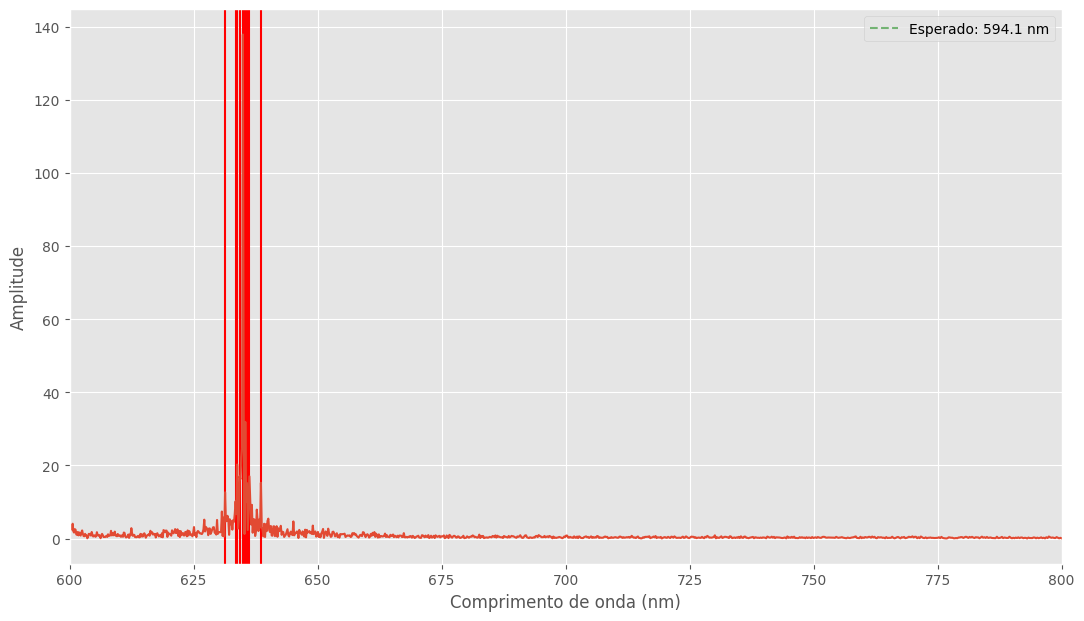

In [9]:
fig, axis = grafico("amarelo2.csv", lambda_esperados=[lambda_amarelo])
fig.savefig("amarelo.png")

## Vermelho +Verde

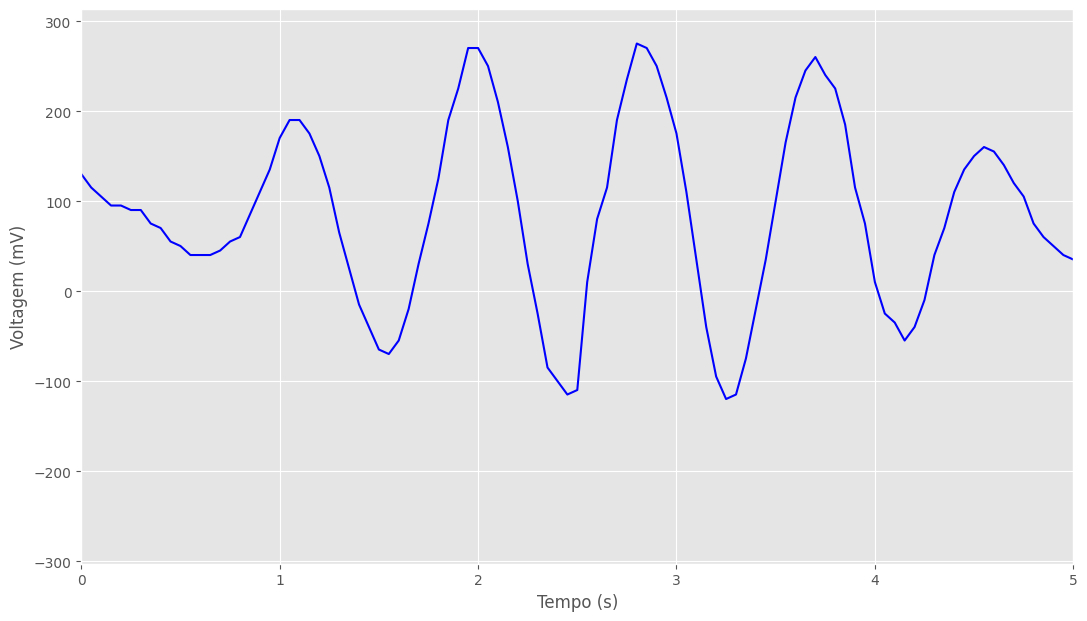

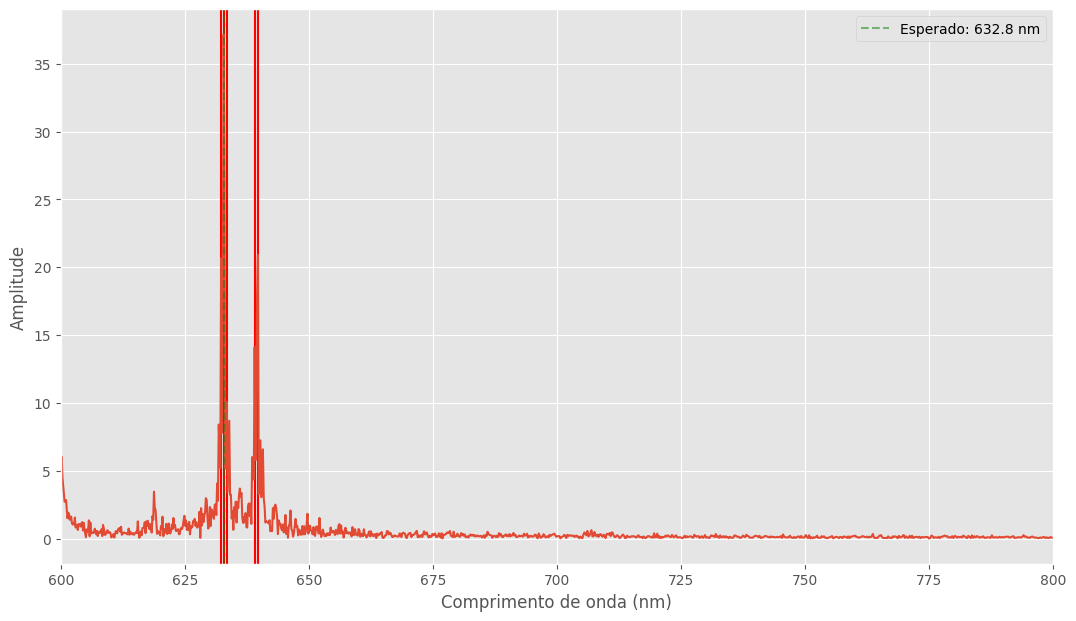

In [10]:
fig, axis = grafico("resultados_vermelho_verde_2.csv", lambda_esperados=[lambda_vermelho])
fig.savefig("vermelho_verde.png")

## Vermelho + Amarelo

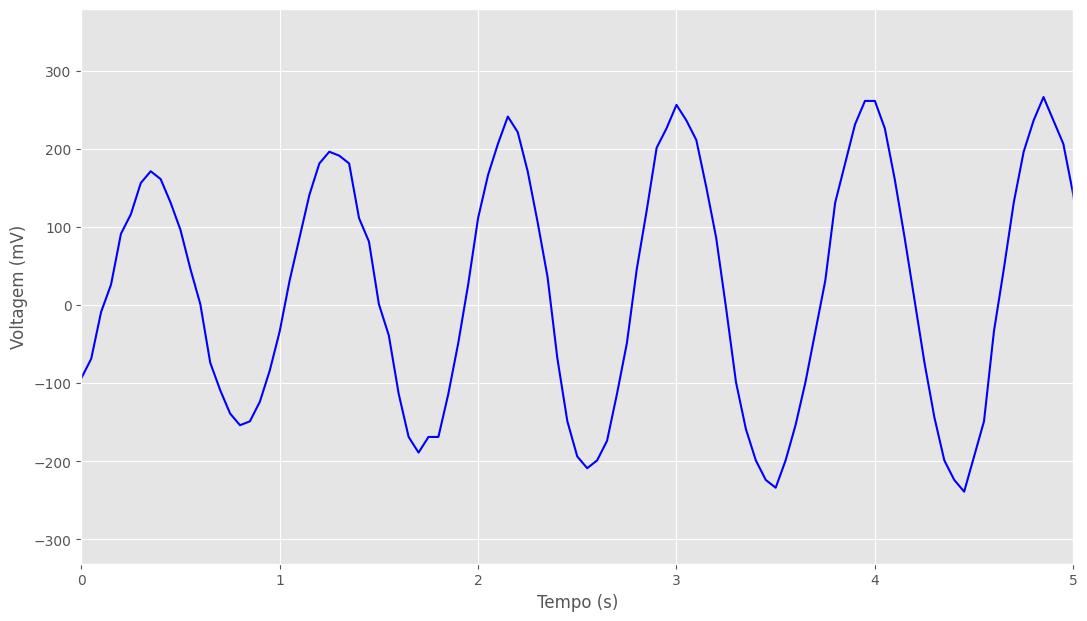

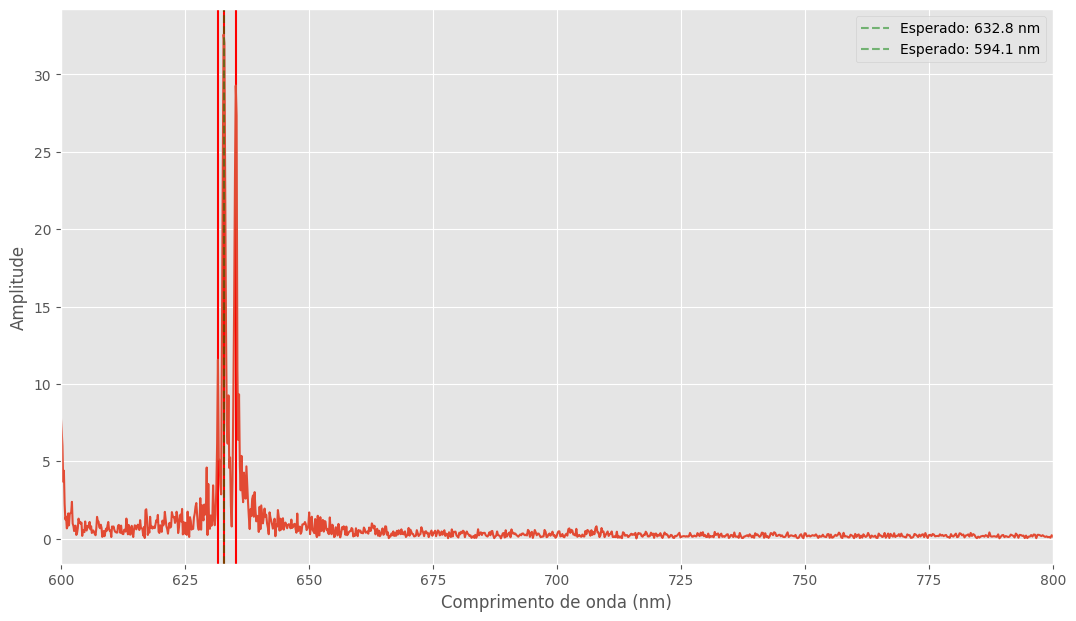

In [11]:
fig, axis = grafico("resultados_amarelo+vermelho2.csv", lambda_esperados=[lambda_vermelho,lambda_amarelo])
fig.savefig("vermelho_amarelo.png")

## Amarelo + Verde

TypeError: 'Medida' object is not subscriptable

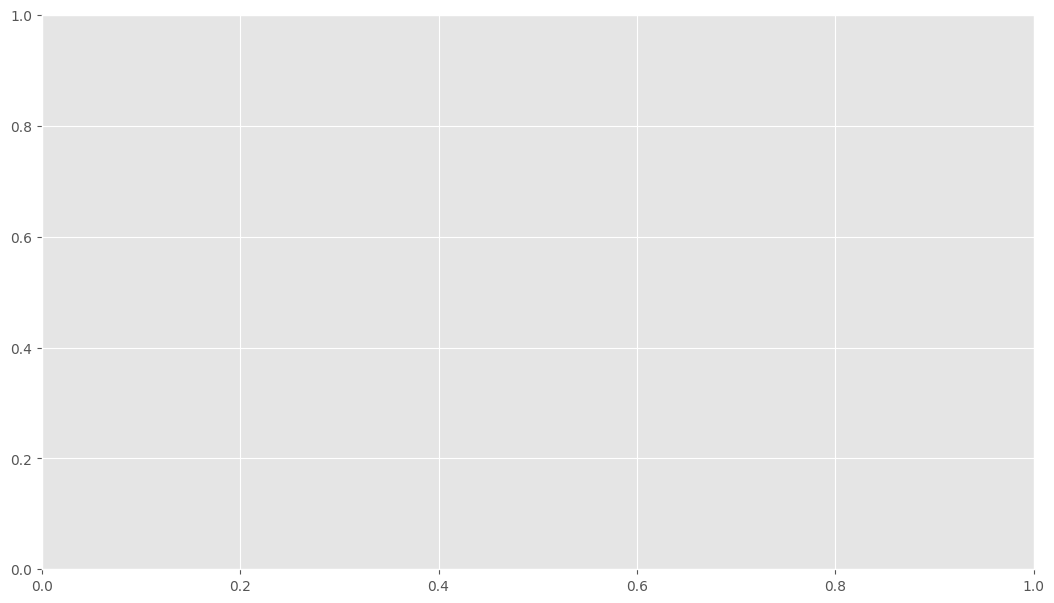

In [12]:
fig, axis = grafico("resultados_amarelho_verde_2.csv",lambda_esperados=[lambda_amarelo], time_interval=lab.Medida(10,"s",0))
fig.savefig("amarelo_verde.png")

## Vermelho + Verde + Amarelo

In [ ]:
fig, axis = grafico("resultado_todos_1.csv", lambda_esperados=[lambda_vermelho,lambda_amarelo],time_interval=lab.Medida(20,"s",0))
fig.savefig("vermelho_verde_amarelo.png")